# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from adspy_shared_utilities import plot_labelled_scatter
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from adspy_shared_utilities import plot_decision_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import time
import sklearn
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib
matplotlib.style.use('ggplot')
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot
from sklearn.metrics import mean_squared_error
from matplotlib import cm
from adspy_shared_utilities import plot_feature_importances
from sklearn.model_selection import StratifiedShuffleSplit

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Function to calculate execution time

In [2]:
class Timer:
  def __init__(self):
    self.start = time.time()

  def restart(self):
    self.start = time.time()

  def get_time(self):
    end = time.time()
    m, s = divmod(end - self.start, 60)
    h, m = divmod(m, 60)
    time_str = "%02d:%02d:%02d" % (h, m, s)
    
    return time_str

# Function to plot correlation between feature variables

In [3]:
#Define a correlation plot method
def Correlation_plot(df,target):
    plt.ioff()
    red_green = ["#ff0000", "#00ff00"]
    sns.set_palette(red_green)
    np.seterr(divide='ignore', invalid='ignore')
    g = sns.pairplot(df,hue=target[0])
                     #diag_kind = 'kde',
                     #hue = "compliance",
                     #markers = ["o", "D"],
                     #size = 1.5,
                     #aspect = 1,
                     #plot_kws = {"s": 6})
    g.fig.subplots_adjust(right = 0.9)
    plt.show()
    
    return

# Function to display evaluation metrics like Accuracy, Precision, etc.

In [4]:
def Eval_Metrics(clf,X_train, X_test, y_train, y_test):
    
    
    print('Accuracy of classifier on training set: {:.2f}'.format(clf.score(X_train, y_train)))
    print ('\nAccuracy of classifier on test set:{:.2f}'.format (clf.score(X_test, y_test)))
    
    y_predicted = clf.predict(X_test)
    
    confusion = confusion_matrix(y_test, y_predicted)
    print('Confusion Matrix:\n', confusion)
    
    # Accuracy = TP + TN / (TP + TN + FP + FN)
    # Precision = TP / (TP + FP)
    # Recall = TP / (TP + FN)  Also known as sensitivity, or True Positive Rate
    # F1 = 2 * Precision * Recall / (Precision + Recall) 
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_predicted)))
    print('Precision: {:.2f}'.format(precision_score(y_test, y_predicted)))
    print('Recall: {:.2f}'.format(recall_score(y_test, y_predicted)))
    print('F1: {:.2f}'.format(f1_score(y_test, y_predicted)))
    print('Classification Report\n', 
          classification_report(y_test, y_predicted, target_names = ['not 1', '1']))
    
    return

# Function to plot correlation between features

In [5]:
def pca_2d_clustering(df_train,X_train_df,y_train_df,X_features,target):   
    
    #PCA to visualize train data
    # Before applying PCA, each feature should be centered (zero mean) and with unit variance
    X_normalized = StandardScaler().fit(X_train_df).transform(X_train_df)
    pca = PCA(n_components = 2).fit(X_normalized)
    
    X_pca = pca.transform(X_normalized)
    print(X_train_df.shape, X_pca.shape)
    
    #Plotting the PCA-transformed versionof the train dataset
    
    plot_labelled_scatter(X_pca, y_train_df, ['True', 'False'])
    
    plt.xlabel('First principal component')
    plt.ylabel('Second principal component')
    plt.title('Blight Ticket Dataset PCA (n_components = 2)');
    
    #Plotting the magnitude of each feature value for the first two principal components
    fig = plt.figure(figsize=(8, 4))
    plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
    feature_names = X_features
    
    plt.gca().set_xticks(np.arange(-.5, len(feature_names)));
    plt.gca().set_yticks(np.arange(0.5, 2));
    plt.gca().set_xticklabels(feature_names, rotation=90, ha='left', fontsize=12);
    plt.gca().set_yticklabels(['First PC', 'Second PC'], va='bottom', fontsize=12);
    
    plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0, 
                                                  pca.components_.max()], pad=0.65);
    
    
    print('\n--------------------------------------Kmeans Clustering------------------------------------------------')
    kmeans = KMeans(n_clusters = 2)
    kmeans.fit(X_pca)
    plot_labelled_scatter(X_pca, kmeans.labels_, ['Cluster 1', 'Cluster 2'])   
    
   

    return

# Function to plot ROC AUC curve

In [6]:
#ROC curves, Area-Under-Curve (AUC)
def ROC_AUC_Curve(clf, X_train, X_test, y_train, y_test, y_score, clf_typ):

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.01])
    plt.plot(fpr, tpr, lw=3, label=clf_typ +' ROC curve (area = {:0.2f})'.format(roc_auc))
    plt.xlabel('False Positive Rate'+clf_typ, fontsize=16)
    plt.ylabel('True Positive Rate'+clf_typ, fontsize=16)
    plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
    plt.legend(loc='lower right', fontsize=13)
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
    plt.axes().set_aspect('equal')

    
    # create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([thresholds[-1],thresholds[0]])
    ax2.set_xlim([fpr[0],fpr[-1]])
    
    plt.show()
    
    return

# Load Data

In [7]:
#Load the data in train.csv file into a data frame called df_train
def load_data():
    df_train_complete = pd.read_csv("train.csv", encoding = 'ISO-8859-1', low_memory=False)
    df_addr = pd.read_csv("addresses.csv", encoding = 'ISO-8859-1', low_memory=False)
    df_latlons = pd.read_csv("latlons.csv", encoding = 'ISO-8859-1', low_memory=False)
    
    return df_train_complete,df_addr,df_latlons

# Prepare Data

In [8]:
def prepare_data(df_train_complete,df_addr,df_latlons):
    
    #exclude observations with Null labels in 'compliance' [target variable for prediction] Null = Not responsible
    df_train = df_train_complete[np.isfinite(df_train_complete['compliance'])]
    df_train = pd.merge(df_train, df_addr, how='left', on=['ticket_id'])
    df_train = pd.merge(df_train, df_latlons, how='left', on=['address'])  

    #replace NaN in lat/long with 0 and add another column to indicate whether the latlon is modified
    df_train=df_train.fillna(0)
    df_train['imputed_latlon'] = df_train['lat'].apply(lambda x: 1 if x == 0 else 0)
    
    
    target= ['compliance']
    y_train_df = df_train['compliance']
    
    X_features = ['fine_amount','admin_fee','state_fee','late_fee','discount_amount','clean_up_cost','judgment_amount','lat','lon','imputed_latlon']
   
    X_train_df = df_train[X_features]
           
    # Normalizing each feature -- centered (zero mean) and with unit variance
    X_normalized = StandardScaler().fit(X_train_df).transform(X_train_df)
    
    #Train test split for cross validation
    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_train_df, random_state = 3)   
    

    
    return df_train,X_train_df,y_train_df,X_features,target, X_train, X_test, y_train, y_test

# Examine Data

In [9]:
def examine_data(df_train,X_train_df,y_train_df,X_features,target):
    
    #Examining the data
    Correlation_plot(df_train[X_features+target], target)
    
    #Principle component analysis and clustering
    pca_2d_clustering(df_train,X_train_df,y_train_df,X_features,target)
        
    
    return

# Dummy Classifier

In [10]:
def dummy_classifier(df_train,X_train_df,y_train_df,X_features,target,X_train,X_test,y_train,y_test):
    
    print('\n--------------------------------------dummy classifier------------------------------------------------')
    # Negative class (0) is most frequent
    #dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
    # produces random predictions w/ same class proportion as training set
    dummy = DummyClassifier(strategy='stratified').fit(X_train, y_train)
    Eval_Metrics(dummy, X_train, X_test, y_train, y_test)
    #ROC_AUC_Curve(dummy, X_train, X_test, y_train, y_test)

    
    return

# Logistic Regression

In [11]:
def logistic_regression(df_train,X_train_df,y_train_df,X_features,target,X_train,X_test,y_train,y_test):
    
    print('\n--------------------------------------logistic regression-------------------------------------------\n-')
    
    lr = LogisticRegression()  
    
    param_grid = {'C': [1000, 10000, 100000], 'penalty': ['l1', 'l2']}
    grid = GridSearchCV(lr, param_grid, scoring = 'roc_auc', cv = StratifiedShuffleSplit(n_splits=5,test_size=0.3,random_state = 0))
    grid.fit(X_train, y_train)
    
    print('Single best score achieved across all params',grid.best_score_)
    print('Dictionary containing the parameters used to generate that score',grid.best_params_)
    print('Shows default parameters that we did not specify', grid.best_estimator_)
        
    lr_best =  LogisticRegression(C = grid.best_params_['C'],
                                  penalty = grid.best_params_['penalty']
                                 )
    
    lr_best.fit(X_train, y_train)
    Eval_Metrics(lr_best, X_train, X_test, y_train, y_test)
    y_score = lr_best.predict_proba(X_test)
    ROC_AUC_Curve(lr_best, X_train, X_test, y_train, y_test,y_score[:,1],'BestLogistic Regression')
    

    
    return

# Decision Tree

In [12]:
def decistion_tree(df_train,X_train_df,y_train_df,X_features,target,X_train,X_test,y_train,y_test):
    
    print('\n---------------------------------------------decision tree-------------------------------------\n')
    
    #plot_decision_tree(dt, X_features, target)
  
    dt = DecisionTreeClassifier(max_depth=5).fit(X_train, y_train)
    
    #plot feature importances
    plt.figure(figsize=(10,6),dpi=80)
    plot_feature_importances(dt, X_features)
    plt.tight_layout()
    plt.show()
    
    
    # Define the parameter values that should be searched
    
    param_grid = {'max_depth': np.arange(6, 8), 'min_samples_split': list(range(48, 100))}
    
    # instantiate the grid
    #grid = GridSearchCV(dtc, param_grid, cv=10, scoring='accuracy')
    grid = GridSearchCV(dt, param_grid, cv=10, scoring='roc_auc')
    
    # fit the grid with data
    grid.fit(X_train, y_train)
                             
    # examine the best model
    print('Single best score achieved across all params',grid.best_score_)
    print('Dictionary containing the parameters used to generate that score',grid.best_params_)
    print('Shows default parameters that we did not specify', grid.best_estimator_)
    
    #best model
    dt_best = DecisionTreeClassifier(max_depth = grid.best_params_['max_depth'],
                                min_samples_split = grid.best_params_['min_samples_split'])
    dt_best.fit(X_train, y_train)
    Eval_Metrics(dt_best, X_train, X_test, y_train, y_test)
    y_score = dt_best.fit(X_train, y_train).predict_proba(X_test)
    ROC_AUC_Curve(dt_best, X_train, X_test, y_train, y_test,y_score[:,1], 'dt')

    
    return

# Random Forest

In [13]:
def random_forest(df_train,X_train_df,y_train_df,X_features,target,X_train,X_test,y_train,y_test):
    
    print('\n-----------------------------------Random Forest-----------------------------------------------------------\n')
       
    param_grid = {'n_estimators': [200, 300, 400],
                  'max_features': ['auto', 'sqrt', 'log2'],
                  'max_depth' : [5,6,7],
                  'criterion' : ['gini', 'entropy']
                 }
    
    grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv= 5, scoring='roc_auc')
    grid.fit(X_train, y_train)

    print('Single best score achieved across all params',grid.best_score_)
    print('Dictionary containing the parameters used to generate that score',grid.best_params_)
    print('Shows default parameters that we did not specify', grid.best_estimator_)
    
    fig, subaxes = plt.subplots(1, 1, figsize=(6, 6))
    title = 'Random Forest Classifier, complex binary dataset, default settings'
    
    RF = RandomForestClassifier(criterion = grid.best_params_['criterion'], 
                                max_depth = grid.best_params_['max_depth'], 
                                max_features = grid.best_params_['max_features'],
                                n_estimators = grid.best_params_['n_estimators'])
    RF.fit(X_train,y_train)
    Eval_Metrics(RF, X_train, X_test, y_train, y_test)
    y_score = RF.fit(X_train, y_train).predict_proba(X_test)
    ROC_AUC_Curve(RF, X_train, X_test, y_train, y_test,y_score[:,1],'rf')
    
  
    return

# Gradient Boosted Decistion Trees (GBDT)

In [14]:
def gb_dt(df_train,X_train_df,y_train_df,X_features,target,X_train,X_test,y_train,y_test):

    print('\n------------------------------Gradient-boosted decision trees----------------------------------------------\n')
    
    #Grid Search
    tuned_params = {'n_estimators': [5, 50], #'n_estimators': [5000, 10000]
                    'max_depth': [2, 10], 
                    'min_samples_split': [2, 10],
                    'learning_rate': [0.01, .1]}
    #print("# Tuning hyper-parameters for mean_squared_error")
    print("# Tuning hyper-parameters for roc_auc")
    grid = GridSearchCV(GradientBoostingClassifier(random_state=0),
                        tuned_params, cv=5, scoring='roc_auc')  # removed loss = 'ls', 
      
    grid.fit(X_train, y_train)
                             
    # examine the best model
    print('Single best score achieved across all params',grid.best_score_)
    print('Dictionary containing the parameters used to generate that score',grid.best_params_)
    print('Shows default parameters that we did not specify', grid.best_estimator_)
    
    gpdt_best =  GradientBoostingClassifier(learning_rate = grid.best_params_['learning_rate'],
                                            min_samples_split = grid.best_params_['min_samples_split'],
                                            n_estimators = grid.best_params_['n_estimators'],
                                            max_depth = grid.best_params_['max_depth']
                                            )
    gpdt_best.fit(X_train, y_train)
    Eval_Metrics(gpdt_best, X_train, X_test, y_train, y_test)
    y_score = gpdt_best.fit(X_train, y_train).predict_proba(X_test)
    ROC_AUC_Curve(gpdt_best, X_train, X_test, y_train, y_test,y_score[:,1],'gbdt')
    
    y_pred = gpdt_best.predict(X_test)

    
    return

In [15]:
# Models

In [ ]:
def blight_model():
    
    my_timer = Timer()
    
    #load data
    df_train_complete,df_addr,df_latlons = load_data()
    elapsed = my_timer.get_time()
    print("\nTotal compute time was: %s" % elapsed)
    
    #Prepare data
    df_train,X_train_df,y_train_df,X_features,target,X_train,X_test,y_train,y_test = prepare_data(df_train_complete,df_addr,df_latlons)
    elapsed = my_timer.get_time()
    print("\nTotal compute time was: %s" % elapsed)
    
    #Examine data
    examine_data(df_train,X_train_df,y_train_df,X_features,target)  
    elapsed = my_timer.get_time()
    print("\nTotal compute time was: %s" % elapsed)
    
    #Dummy classifier
    dummy_classifier(df_train,X_train_df,y_train_df,X_features,target,X_train,X_test,y_train,y_test)
    elapsed = my_timer.get_time()
    print("\nTotal compute time was: %s" % elapsed)
    
    #Logistic regression
    logistic_regression(df_train,X_train_df,y_train_df,X_features,target,X_train,X_test,y_train,y_test)
    elapsed = my_timer.get_time()
    print("\nTotal compute time was: %s" % elapsed)
    
    #Decision tree
    decistion_tree(df_train,X_train_df,y_train_df,X_features,target,X_train,X_test,y_train,y_test)
    elapsed = my_timer.get_time()
    print("\nTotal compute time was: %s" % elapsed)
   
    #Random forest
    random_forest(df_train,X_train_df,y_train_df,X_features,target,X_train,X_test,y_train,y_test)
    elapsed = my_timer.get_time()
    print("\nTotal compute time was: %s" % elapsed)
    
    #Gradient-boosted decision trees
    gb_dt(df_train,X_train_df,y_train_df,X_features,target,X_train,X_test,y_train,y_test)
    elapsed = my_timer.get_time()
    print("\nTotal compute time was: %s" % elapsed)
    
    #==========================================================================================================
    
    #Load the data in test.csv file into a data frame called df_test
    #df_test = pd.read_csv("test.csv", encoding = 'ISO-8859-1', low_memory=False)
    #X_test = df_test[X_features]
    
    #X_test['predicted_probability'] = lr.predict_proba(X_test)
    #predict_proba = lr.predict_proba(X_test)    
    #probability = predict_proba[:,1]
    #predict = lr.predict(X_test)    
    #df_test['compliance'] = probability.tolist()
    #df_test['predict'] = predict.tolist()
    
    #df = df_test[['ticket_id','compliance']]
    #df=df.set_index('ticket_id')
    
    return  #pd.Series(df['compliance'])
    


Total compute time was: 00:00:02

Total compute time was: 00:00:03


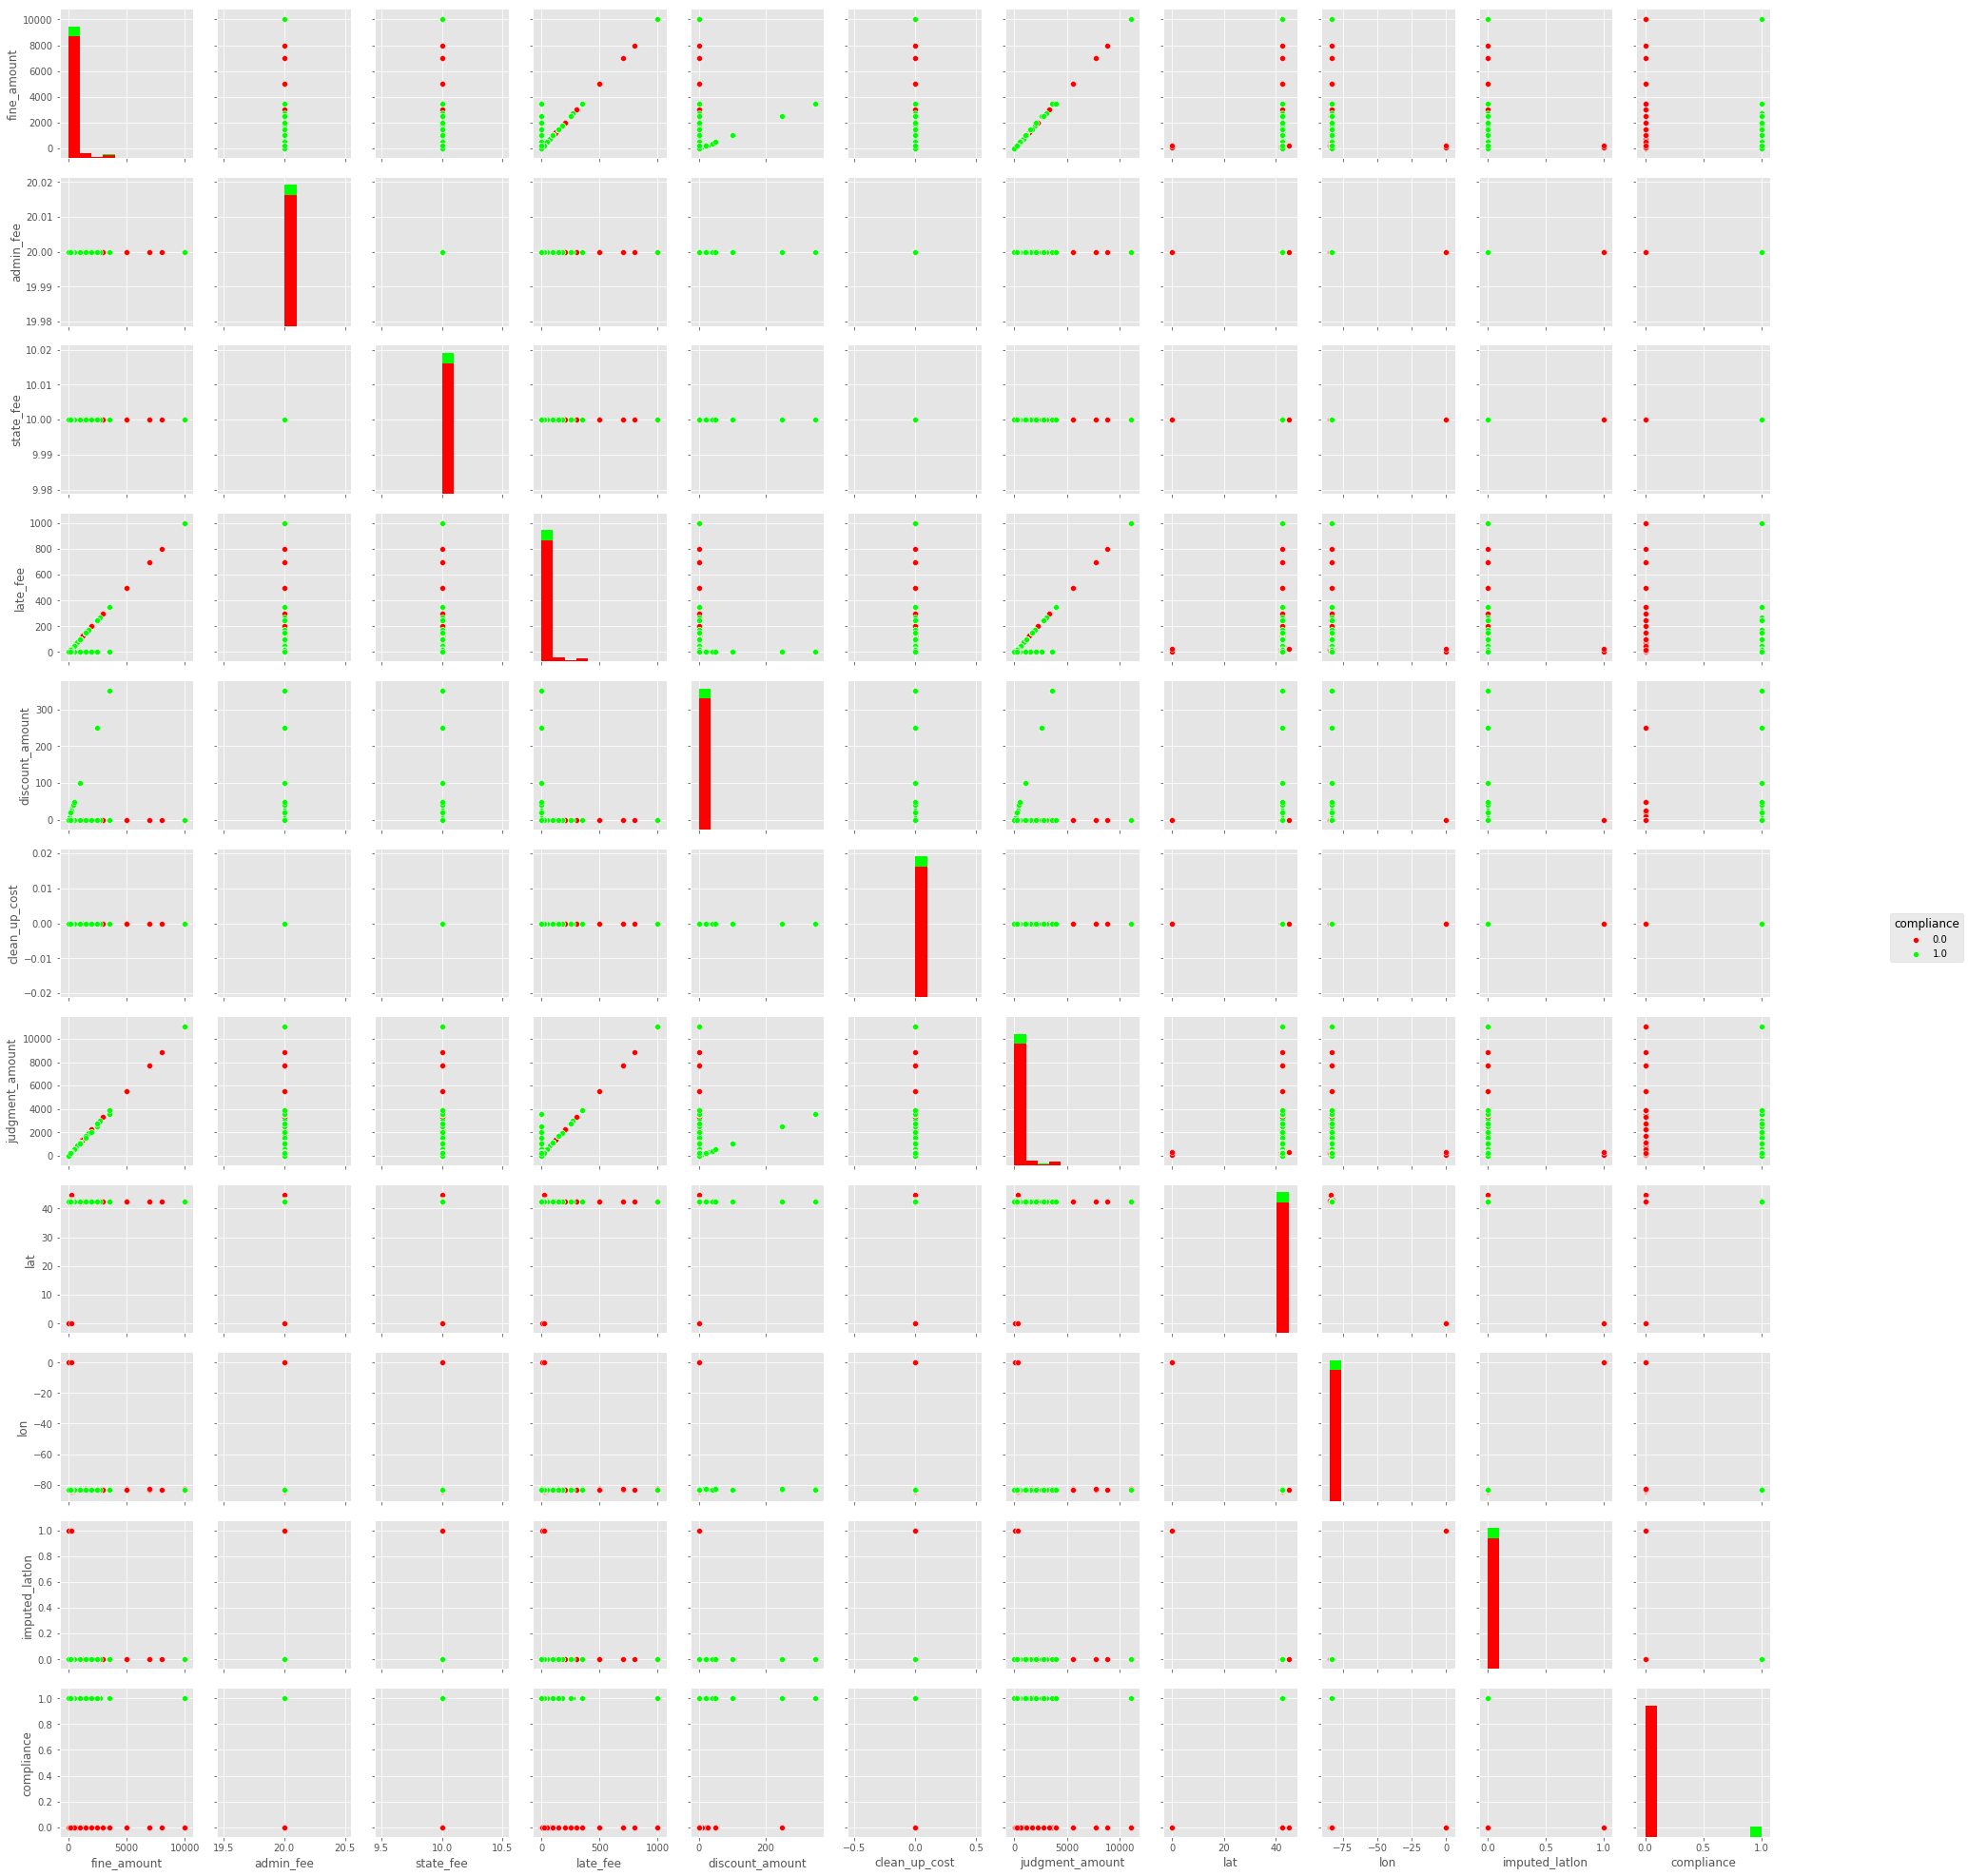

(159880, 10) (159880, 2)


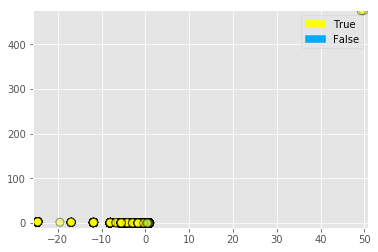


--------------------------------------Kmeans Clustering------------------------------------------------


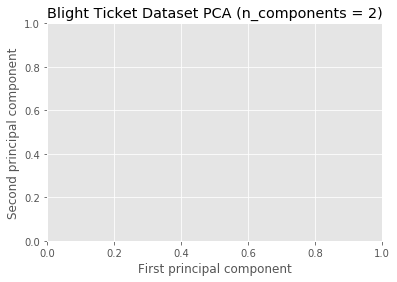

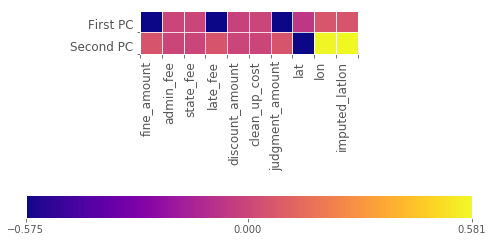

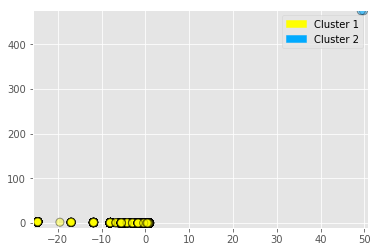


Total compute time was: 00:04:15

--------------------------------------dummy classifier------------------------------------------------
Accuracy of classifier on training set: 0.86

Accuracy of classifier on test set:0.86
Confusion Matrix:
 [[34415  2737]
 [ 2624   194]]
Accuracy: 0.87
Precision: 0.07
Recall: 0.07
F1: 0.07
Classification Report
              precision    recall  f1-score   support

      not 1       0.93      0.93      0.93     37152
          1       0.07      0.07      0.07      2818

avg / total       0.87      0.87      0.87     39970


Total compute time was: 00:04:15

--------------------------------------logistic regression-------------------------------------------
-
Single best score achieved across all params 0.7541655412885049
Dictionary containing the parameters used to generate that score {'C': 100000, 'penalty': 'l1'}
Shows default parameters that we did not specify LogisticRegression(C=100000, class_weight=None, dual=False,
          fit_intercept=True

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


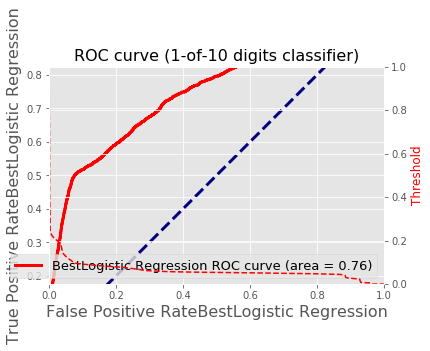


Total compute time was: 00:53:16

---------------------------------------------decision tree-------------------------------------



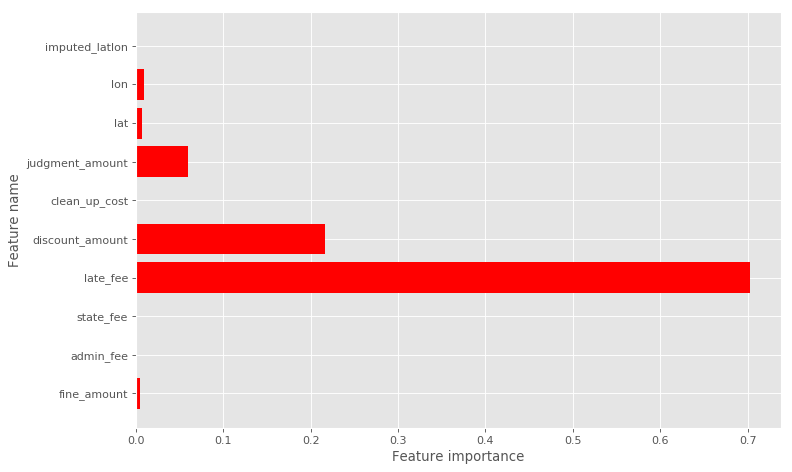

Single best score achieved across all params 0.7623828378215148
Dictionary containing the parameters used to generate that score {'max_depth': 7, 'min_samples_split': 55}
Shows default parameters that we did not specify DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=55,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Accuracy of classifier on training set: 0.94

Accuracy of classifier on test set:0.94
Confusion Matrix:
 [[37112    40]
 [ 2492   326]]
Accuracy: 0.94
Precision: 0.89
Recall: 0.12
F1: 0.20
Classification Report
              precision    recall  f1-score   support

      not 1       0.94      1.00      0.97     37152
          1       0.89      0.12      0.20      2818

avg / total       0.93      0.94      0.91     39970



C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


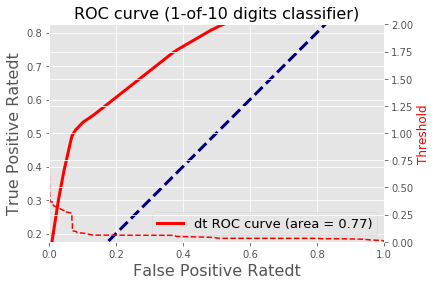


Total compute time was: 01:05:23

-----------------------------------Random Forest-----------------------------------------------------------



In [ ]:
df_train = blight_model()